# DASi to Aquarium

**Inputs**

* `design.out.json`
* `design.out.resolved.json` <- design output with resolveda aquarium sequences
* `SelectedInventory.csv`

**Outputs**

In [2]:
import pandas as pd
import json

In [11]:
# login to Benchling & Aquarium
from aqbt.tools import config_to_sessions
from aqbt.tools import parse_config
import toml

def config(config_path):
    with open(config_path, "r") as f:
        return parse_config(toml.load(f))


def sessions(config):
    return config_to_sessions(config)


sessions = sessions(config('config.toml'))

benchling = sessions['default']['benchling']
registry = sessions['default']['registry']
session = sessions['default']['aquarium']
sessions

{'default': {'aquarium': <AqSession(name=None, AqHTTP=<AqHTTP(user='vrana', url='http://52.27.43.242')>), parent=94039747511136)>,
  'benchling': <benchlingapi.session.Session at 0x7f99b0d71c10>,
  'registry': <aqbt.aquarium.registry.LabDNARegistry at 0x7f99b0c04670>}}

##### Load `SelectedInventory.csv`

In [12]:
inv_df = pd.read_csv("SelectedInventory.csv", index_col=0)
inv_df.head()

,entity_registry_id,is_available,is_circular,record,record_uuid,sample,sample_id,sample_type,sequence_hash
286,NaN,True,False,ID: 1010__vf2\nName: vf2\nDescription: <unknow...,b227364f-4708-4976-a960-34e8fb019670,<Sample id=1010 name=vf2 sample_type={'rid': 1...,1010,Primer,ed119701ab23e88921ecee8ef629a110265c65ae
287,NaN,True,False,ID: 1014__c-myc-F\nName: c-myc-f\nDescription:...,e27abdee-dda1-4ede-8975-2c2f43d631f8,<Sample id=1014 name=c-myc-F sample_type={'rid...,1014,Primer,d48a98059541b2acf77b13bf59645a5f3cdc5ca5
288,NaN,True,False,ID: 1015__trp_F\nName: trp_f\nDescription: <un...,365e36ea-ec97-4e5f-88a5-3a21ae2e8077,<Sample id=1015 name=trp_F sample_type={'rid':...,1015,Primer,78dd1501c912b9f080e72e7854fa6385e01d0757
289,NaN,True,False,ID: 1016__cen6_F\nName: cen6_f\nDescription: <...,df022340-6045-4368-9e20-4daa01642695,<Sample id=1016 name=cen6_F sample_type={'rid'...,1016,Primer,323188271e4745f3d111680404159569e643890b
290,NaN,True,False,ID: 1039__PP2-Gal1m-f\nName: pp2-gal1m-f\nDesc...,fb3ff6dc-edf5-40dd-8171-83f3ac2d1d3b,<Sample id=1039 name=PP2-Gal1m-f sample_type={...,1039,Primer,bb336cb902b7593df17ca1ee42113f3a54b75912


##### Load `design.out.json`

In [13]:
with open('design.out.json', 'r') as f:
    design_out = json.load(f)
    
print(design_out.keys())
design_out['metadata']

dict_keys(['metadata', 'designs', 'molecules', 'reactions'])


{'program': 'dasi',
 'version': '0.0.21',
 'execution_trace': {'compile': {'__name__': 'compile',
   '__spec__': "FullArgSpec(args=['self', 'n_jobs', 'post_processing_kwargs'], varargs=None, varkw=None, defaults=(10, None), kwonlyargs=[], kwonlydefaults=None, annotations={'n_jobs': <class 'int'>, 'post_processing_kwargs': typing.Dict})",
   'start': '2020-07-21 07:03:44.579428',
   'end': '2020-07-21 07:06:49.781327',
   'args': {'n_jobs': 6, 'post_processing_kwargs': None},
   'algorithm': 'library optimization'},
  'optimize': {'__name__': 'optimize',
   '__spec__': "FullArgSpec(args=['self', 'n_paths', 'n_jobs'], varargs=None, varkw=None, defaults=(3, 10), kwonlyargs=[], kwonlydefaults=None, annotations={'return': typing.Dict[str, dasi.design.design.DesignResult], 'n_paths': <class 'int'>, 'n_jobs': <class 'int'>})",
   'start': '2020-07-21 07:06:49.781447',
   'end': '2020-07-21 07:07:29.300317',
   'args': {'n_paths': 1, 'n_jobs': 6},
   'algorithm': 'library optimization'}}}

### Convert Output to Aquarium Input Spreadsheets

In [68]:
from uuid import uuid4
import hashlib
from tqdm import tqdm_notebook as tqdm
import json

registry = sessions['default']['registry']
session = registry.session

PREFIX = "PlantTF_2020_Campaign_"
primer_type = session.SampleType.find_by_name('Primer')
fragment_type = session.SampleType.find_by_name('Fragment')
plasmid_type = session.SampleType.find_by_name('Plasmid')
# recycler = SampleRecycler(session)


def seq_sha1(seq: str) -> str:
    """Convert sequence string into a hash"""
    return hashlib.sha1(seq.strip().upper().encode()).hexdigest()

def new_name(molecule):
    name = molecule['__name__']
    if name == "PRIMER":
        typename = 'Primer'
    elif 'PCR' in name:
        typename = 'Fragment'
    elif name in ['GAP', 'SHARED_SYNTHESIZED_FRAGMENT']:
        typename = 'Synthesized'
    else:
        raise ValueError
    
    seqhash = seq_sha1(molecule['sequence']['bases'])
    return '{}_{}_{}'.format(typename, PREFIX, seqhash[-8:])

def new_sample(sample_type, name, description, project, properties):
    new_sample = sample_type.new_sample(
        name=name,
        description=description,
        project=project,
        properties=properties
    )
#     sample = recycler.reuse(sample_type.id)
    sample = None
    if sample:
        for fv in sample.field_values:
            assert fv.value is None
            assert fv.child_sample_id is None
            assert fv.sample is None
        sample.name = new_sample.name
        sample.description = new_sample.description
        sample.update_properties(new_sample.properties)
        sample.needs_update = True
    else:
        sample = new_sample
    return sample

def _resolve_primer(m, inv_df):
    row = inv_df[inv_df['sequence_hash'] == seq_sha1(m['sequence']['bases'])]
    if len(row):
        sample_id = int(row['sample_id'].values[0])
        
        assert sample_id
        sample = session.Sample.find(sample_id)
        assert sample
        return sample
    else:
        return new_sample(sample_type=primer_type,
            name=new_name(m),
            description='dasi designed',
            project='SD2',
            properties={
                'Anneal Sequence': m['__meta__']['SEQUENCE'],
                'Overhang Sequence': m['__meta__']['OVERHANG'],
                'T Anneal': round(m['__meta__']['TM'] - 2, 2)
            }
        )
    
def _resolve_fragment(m, results, df):
    reactions = m['used_as_output_to_reactions']
    assert len(reactions) == 1
    inputs = results['reactions'][reactions[0]]['inputs']
    input_molecules = [results['molecules'][i] for i in inputs]
    primers = [m for m in input_molecules if m['__name__'] == 'PRIMER']
    templates = [m for m in input_molecules if m['__name__'] == 'TEMPLATE']
    assert len(primers) == 2
    assert len(templates) == 1
    
    fwd = _resolve_primer(primers[0], df)
    rev = _resolve_primer(primers[1],df)
    
    return new_sample(
        sample_type=fragment_type,
        name=new_name(m),
        description='dasi designed',
        project='SD2',
        properties={
            'Forward Primer': fwd,
            'Reverse Primer': rev,
            'Template': _resolve_template(templates[0]),
            'Length': len(m['sequence']['bases']),
            'Sequence': '',
        }
    )


    
def _resolve_template(m):
    lims_id = m['sequence']['LIMS_ID']
    assert lims_id
    sample = session.Sample.find(lims_id)
    assert sample
    return sample

def _resolve_gblock(m):
    return new_sample(
        sample_type=fragment_type,
        name=new_name(m),
        description='dasi designed',
        project='SD2',
        properties={
            'Sequence': m['sequence']['bases'],
            'Length': len(m['sequence']['bases'])
        }
    )

def _resolve_plasmid(m):
    return new_sample(
        sample_type=plasmid_type,
        name=m['sequence']['name'],
        description='dasi designed',
        project='SD2',
        properties={
            'Sequence': m['sequence']['bases'],
            'Length': len(m['sequence']['bases']),
            'Bacterial Marker': 'Amp'
        }
    )
    
def _resolve_molecule(m, results, df):
    if m['__name__'] in ['GAP', 'SHARED_SYNTHESIZED_FRAGMENT']:
        return _resolve_gblock(m)
    elif m['__name__'] in ['PCR_PRODUCT', 'PCR_PRODUCT_WITH_LEFT_PRIMER',
                          'PCR_PRODUCT_WITH_RIGHT_PRIMER', 'PCR_PRODUCT_WITH_PRIMERS']:
        return _resolve_fragment(m, results, df)
    elif m['__name__'] == 'TEMPLATE':
        return _resolve_template(m)
    elif m['__name__'] == 'PRE-MADE DNA FRAGMENT':
        return _resolve_template(m)
    elif m['__name__'] == 'PRIMER':
        return _resolve_primer(m, df)
    elif m['__name__'] == 'PLASMID':
        return _resolve_plasmid(m)
    else:
        raise ValueError(m['__name__'] + " not recognized")

def resolve_molecules(results, df):
    molecules = results['molecules']
    for m in molecules:
        m['__sample__'] = None

    for m in molecules:
        resolved = _resolve_molecule(m, results, df)
        if resolved:
            m['__sample__'] = resolved
    return molecules

In [ ]:
##################
# Submit
##################

from pydent import Planner
from pydent import save_inventory

resolve_molecules(design_out, inv_df)
design_id = seq_sha1(json.dumps(design_out['designs']))

##################
# Save inventory
##################
all_samples = [m['__sample__'] for m in design_out['molecules']]
new_samples = [m['__sample__'] for m in design_out['molecules'] if not m['__sample__'].id]

##################
# Update samples
##################
to_update = [m['__sample__'] for m in design_out['molecules'] if hasattr(m['__sample__'], 'needs_update')]

print(len(new_samples))
print(len(to_update))

In [70]:
design_out['metadata']

102
0


{'program': 'dasi',
 'version': '0.0.21',
 'execution_trace': {'compile': {'__name__': 'compile',
   '__spec__': "FullArgSpec(args=['self', 'n_jobs', 'post_processing_kwargs'], varargs=None, varkw=None, defaults=(10, None), kwonlyargs=[], kwonlydefaults=None, annotations={'n_jobs': <class 'int'>, 'post_processing_kwargs': typing.Dict})",
   'start': '2020-07-21 07:03:44.579428',
   'end': '2020-07-21 07:06:49.781327',
   'args': {'n_jobs': 6, 'post_processing_kwargs': None},
   'algorithm': 'library optimization'},
  'optimize': {'__name__': 'optimize',
   '__spec__': "FullArgSpec(args=['self', 'n_paths', 'n_jobs'], varargs=None, varkw=None, defaults=(3, 10), kwonlyargs=[], kwonlydefaults=None, annotations={'return': typing.Dict[str, dasi.design.design.DesignResult], 'n_paths': <class 'int'>, 'n_jobs': <class 'int'>})",
   'start': '2020-07-21 07:06:49.781447',
   'end': '2020-07-21 07:07:29.300317',
   'args': {'n_paths': 1, 'n_jobs': 6},
   'algorithm': 'library optimization'}}}

### Lint Samples

In [71]:
from aqbt.aquarium import Linter
linter = Linter()
# TODO:

### Create Spreadsheets

In [ ]:
from typing import List
from pydent.models import Sample
import dictdiffer

def samples_to_dfs(session, samples: List[Sample], project):
    sample_by_st = {}
    with session.with_cache(timeout=60) as sess:
        sess.browser.get(samples, {
            'sample_type': {
                'field_types': 'allowable_field_types'
            },
            'field_values': {
                'sample': 'sample_type',
                'field_type': [],
                'allowable_field_type': []
            }
        })
    for s in samples:
        sample_by_st.setdefault(s.sample_type.name, {
            'samples': [],
            'sample_type': s.sample_type
        })
        sample_by_st[s.sample_type.name]['samples'].append(s)
        
    data = {}
    for k, v in sample_by_st.items():
        data[k] = _samples_to_df(v['samples'], v['sample_type'], project)
    return data

def _resolve_field_value(fv):
    if fv.ftype == 'sample':
        if fv.sample:
            return fv.sample.name
        elif fv.child_sample_id:
            return fv.child_sample_id
    else:
        return fv.value
    
def _samples_to_df(samples, sample_type, project):
    prop_columns = []
    for ft in sample_type.field_types:
        if ft.array:
            prop_columns.append([ft.name])
        else:
            prop_columns.append(ft.name)
    columns = [sample_type.name, 'Description', 'Project'] + prop_columns
    
    rows = []
    for s in samples:
        row = {
            sample_type.name: s.name,
            'Description': s.description,
            'Project': project
        }
        for prop in prop_columns:
            if isinstance(prop, list):
                pass
            else:
                v = s.properties[prop]
                if isinstance(v, Sample):
                    v = v.name
                row[prop] = v
        rows.append(row)
    
    return pd.DataFrame(rows)


# existing samples
with session(using_cache=False) as sess:
    names = [s.name for s in new_samples]
    existing = sess.query({
        '__model__': 'Sample',
        '__query__': {
            'name': names
        }
    })
    existing_by_name = {s.name: s for s in existing}

def props(s):
    if not s.field_values:
        return {}
    data = s.properties
    for k, v in data.items():
        if v.__class__.__name__ == 'Sample':
            data[k] = v.id
    return data
            
    
def compare_samples(s1, s2):
    d1 = props(s1)
    d2 = props(s2)
    return list(dictdiffer.diff(d1, d2))

    
assert compare_samples(new_samples[0], new_samples[1])
assert not compare_samples(new_samples[0], new_samples[0])

from typing import Tuple, List

def update_samples(update_from_left_to_right: List[Tuple[Sample, Sample]]):
    """Safely update samples, carefully validating server and local Sample properties."""
    needs_updating = update_from_left_to_right

    for s1, s2 in needs_updating:
        with session(using_cache=False) as sess:
            sample_from_server = sess.Sample.find(s2.id)
        diff = compare_samples(s1, sample_from_server)
        if not diff:
            s1.id = sample_from_server.id
            print("Does not need update: {}:{}".format(s1.id, s1.name))
        else:
            print("Updating {}:{}".format(s2.id, s2.name))
            s2.update_properties(s1.properties)
            # attempt server update
            s2.update()

            with session(using_cache=False) as sess:
                s3 = sess.Sample.find(s2.id)
            diff = compare_samples(s2, s3)
            if diff:
                raise Exception("Update not successful")

needs_updating = []
needs_saving = []
    
# attempt update on existing samples
print("*" * 10 + " Validating samples " + "*" * 10)
for s in new_samples:
    if s.name in existing_by_name:
        s2 = existing_by_name[s.name]
        diff = compare_samples(s, s2)
        if diff:
            needs_updating.append((s, s2))
        elif s.id is None:
            s.id = s2.id
            print('Updating id: {}:{}'.format(s.id, s2.name))
        else:
            print("Sample validated: {}:{}".format(s.id, s.name))
    else:
        needs_saving.append(s)
            
print("{} samples need saving".format(len(needs_saving)))

print("{} samples need updating".format(len(needs_updating)))
update_samples(needs_updating)

********** Validating samples **********
Sample validated: 34866:pMOD6_backbone_Input_node_be_jub1
Sample validated: 34867:pMOD6_backbone_Input_node_be_ataf1
Sample validated: 34868:pMOD6_backbone_Input_node_be_ant
Sample validated: 34869:pMOD6_backbone_Input_node_be_anac102
Sample validated: 34870:Synthesized_PlantTF_2020_Campaign__75bf7a05
Sample validated: 34871:pMOD6_backbone_Input_node_doxy_jub1
Sample validated: 34872:Synthesized_PlantTF_2020_Campaign__2b82fcbb
Sample validated: 34873:pMOD6_backbone_Input_node_doxy_ataf1
Sample validated: 34874:pMOD6_backbone_Input_node_doxy_anac102
Sample validated: 34898:pMOD-HO-KanMX_output_node_4b2_anac102_stable_gfp
Sample validated: 34901:pMOD-HO-KanMX_output_node_6b2_ataf1_stable_gfp
Sample validated: 34902:pMOD-HO-KanMX_output_node_2b2_ant_stable_gfp
Sample validated: 34903:pMOD-HO-KanMX_output_node_6b2_anac102_stable_gfp
Sample validated: 34904:pMOD-HO-KanMX_output_node_6b2_jub1_stable_gfp
Sample validated: 34905:pMOD-HO-KanMX_output_nod

In [78]:
upload_dfs = samples_to_dfs(session, needs_saving, project='YG-Four-inducible-plantTF-circuits')

for k, v in upload_dfs.items():
    v.to_csv("Upload_{}.csv".format(k), index=False)
    
print("*"*15 + ' To Upload: ' + "*"*15)
print("Step 1: Upload `{}`".format('Upload_Primer.csv'))
print("Step 2: Upload `{}`".format('Upload_Fragment.csv'))
print("Step 3: Upload `{}`".format('Upload_Plasmid.csv'))

*************** To Upload: ***************
Step 1: Upload `Upload_Primer.csv`
Step 2: Upload `Upload_Fragment.csv`
Step 3: Upload `Upload_Plasmid.csv`


## Resolve Design output and save

This dumps the Sample.json for each molecule in the design.out. Saves this file as `design.out.resolved.json`

In [94]:
def dump_sample(sample):
    props = {}
    for k, v in sample.properties.items():
        if isinstance(v, Sample):
            props[k] = {
                '__model__': 'Sample',
                'sample_type': {
                    'name': v.sample_type.name,
                    'id': v.sample_type_id
                },
                'name': v.name,
                'id': v.id
            }
        else:
            props[k] = v
    data = sample.dump()
    data['properties'] = props
    return data
    
from copy import deepcopy

copied_results = deepcopy(design_out)
for m in copied_results['molecules']:
    m['__sample__'] = dump_sample(m['__sample__'])
resolved_results = copied_results

with open('design.out.resolved.json', 'w') as f:
    json.dump(resolved_results, f)


## Visualize

<ipython-input-79-81567689251c>:220: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  isinstance(kwargs["node_color"], collections.Sequence) and


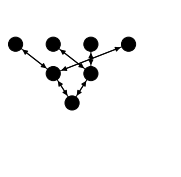

In [79]:
#@title Graph Plotter

import collections
import numpy as np
import networkx as nx
import pylab as plt
%matplotlib inline

def sorted_center(iterable, reverse=False, key=None, select=None):
    centered = []
    s = sorted(iterable, key=key, reverse=reverse)
    front = False
    for v in s:
        if not front:
            centered.append(v)
        else:
            centered.insert(0, v)
        front = not front
    if select:
        return [select(_x) for _x in centered]
    return centered

class GraphPlotter(object):
  
  def __init__(self, graph, ax=None, pos=None):
    if ax is None:
      ax = plt.figure(figsize=(3,3)).gca()
      ax.axis('off')
      ax.set_xlim(0, 1.0)
      ax.set_ylim(0, 1.0)
    
    self._ax = ax
    self._graph = graph
    if pos is None:
      self._pos = dict()
      self.spring_layout()
    else:
      self._pos = pos
      
  @property
  def _base_draw_kwargs(self):
    return dict(G=self._graph, ax=self._ax, pos=self._pos)
 
  def topological_sort(self):
    xlim = self._ax.get_xlim()
    ylim = self._ax.get_ylim()
    
    x = xlim[1] - xlim[0]
    y = ylim[1] - ylim[0]
    xspacer = x * 0.05
    yspacer = y * 0.05
    
    new_xlim = (xlim[0] + xspacer, xlim[1] - xspacer)
    new_ylim = (ylim[0] + yspacer, ylim[1] - yspacer)
    pos = self._topological_sort(self._graph, 
                                 xlim=new_xlim, 
                                 ylim=new_ylim)
    self._pos = pos

  @staticmethod
  def _roots_and_leaves(G, include_cycles=False):
    roots = [k for k, v in G.in_degree(G.nodes) if v == 0]
    leaves = [k for k, v in G.out_degree(G.nodes) if v == 0]
    
    if include_cycles:
      for c in nx.simple_cycles(G):
        outdegree = list(G.out_degree(c))
        outdegree.sort(key=lambda x: x[1])
        leaves.append(outdegree[0][0])

        indegree = list(G.out_degree(c))
        indegree.sort(key=lambda x: x[1])
        roots.append(indegree[0][0])
    return roots, leaves
  
  @classmethod
  def _get_roots(cls, G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[0]

  @staticmethod
  def _get_leaves(G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[1]

  @staticmethod
  def _get_subgraphs(graph):
    """Get independent subgraphs"""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs

  @classmethod
  def _topological_sort(cls, G, xlim=None, ylim=None):
    if xlim is None:
        xlim = [0.05, 0.95]
    if ylim is None:
        ylim = [0.05, 0.95]
    
    rts = cls._get_roots(G, include_cycles=True)
    max_depth = {}
    for root in rts:
        depths = nx.single_source_shortest_path_length(G, root)
        for n, d in depths.items():
            max_depth[n] = max(max_depth.get(n, d), d)

    by_depth = collections.OrderedDict()

    for node, depth in max_depth.items():
        by_depth.setdefault(depth, [])
        by_depth[depth].append(node)
    
    # center nodes with highest degree
    for depth, nodes in by_depth.items():
        centered = sorted_center(list(G.degree(nodes)), 
                                 key=lambda x: x[1], 
                                 reverse=True,
                                select=lambda x: x[0])
        by_depth[depth] = centered

    # push roots 'up' so they are not stuck on layer one
    for root in rts:
        successors = list(G.successors(root))
        if len(successors) > 0:
            min_depth = min([max_depth[s] for s in successors])
            max_depth[root] = min_depth - 1

    # assign positions

    y_min_max = xlim
    x_min_max = ylim
    max_width = max([len(layer) for layer in by_depth.values()])

    y_step = (y_min_max[1] - y_min_max[0]) / (max(by_depth.keys())+1)
    x_step = (x_min_max[1] - x_min_max[0]) / (max_width )
    positions = {}

    for depth in sorted(by_depth):
        y = y_step * depth + y_min_max[0]
        node_ids = by_depth[depth]
        w = len(node_ids)
        delta_w = max_width - w
        for i, n in enumerate(node_ids):
            x_offset = delta_w * x_step / 2.0
            x = x_min_max[0] + x_offset + i * x_step
            positions[n] = (x, y)
    return positions

  def spring_layout(self, **kwargs):
    pos = nx.spring_layout(self._graph, **kwargs)
    self._pos.update(pos)
    return self._pos
    
  @property
  def nodes(self):
    return self._graph.nodes
  
  @property
  def edges(self):
    return self._graph.edges
  
  def node_attrs(self):
    keys = set()
    for _, node_data in self._graph.nodes(data=True):
      keys.update(set(node_data.keys()))
    attrs = {}
    for _, node_data in self._graph.nodes(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(node_data.get(k, None))
    return attrs
  
  def edge_attrs(self):
    keys = set()
    for _, _, edge_data in self._graph.edges(data=True):
      keys.update(set(edge_data.keys()))
    attrs = {}
    for _, _, edge_data in self._graph.edges(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(edge_data.get(k, None))
    return attrs
  
  def map_edge_attrs(self, attrs, source, target):
    vals = [self._normalize(self.edge_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def map_node_attrs(self, attrs, source, target):
    vals = [self._normalize(self.node_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def _normalize(arr, source, target):
    x = source[1] - source[0]
    y = target[1] - target[0]
    return [_x/x * y + target[0] for _x in arr] 
  
  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs
  
  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try:
        # This is for compatibility with older matplotlib.
        collection.set_zorder(zorder)
      except AttributeError:
        # This is for compatibility with newer matplotlib.
        collection[0].set_zorder(zorder)
    return collection

  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)
  
  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

  
  
g = nx.balanced_tree(2, 2)
g = nx.to_directed(g)

for e in g.edges:
  g.edges[e[0], e[1]]['weight'] = 1
  
ax = plt.figure(figsize=(3,3)).gca()
ax.axis('off')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
    
plotter = GraphPlotter(g, ax=ax)
plotter.topological_sort()

plotter.draw_graph(node_color=(0, 0, 0), edge_width=plotter.edge_attrs()['weight'])

In [88]:
design_out['molecules'][10]

{'__name__': 'PRIMER',
 '__index__': 10,
 '__type__': 'molecule',
 '__meta__': {'PENALTY': 15.580078907081713,
  'SEQUENCE': 'ATTAGTTATGTCACGCTTACATTCACGCCC',
  'location': [6557, 30],
  'TM': 65.58007890708171,
  'GC_PERCENT': 43.333333333333336,
  'SELF_ANY_TH': 3.575421125428818,
  'SELF_END_TH': 0.0,
  'HAIRPIN_TH': 38.48822372520124,
  'END_STABILITY': 6.13,
  'OVERHANG': '',
  'SUBJECT_KEY': 'a7c9ac40-4941-4639-941c-ca082c6b9745'},
 'sequence': {'bases': 'ATTAGTTATGTCACGCTTACATTCACGCCC',
  'length': 30,
  'name': '<unknown name>',
  'id': '<unknown id>',
  'annotations': [],
  'customFields': {},
  'isCircular': False},
 'used_in_assemblies': [{'design_key': '0f70b3d0-c89c-4c0f-943e-7ef9b4d79cd3',
   'assembly': 0},
  {'design_key': '181cc88d-dd0c-4669-87dc-0a2ee305d025', 'assembly': 0},
  {'design_key': '19b90e70-04b7-4d44-ac2a-d308f6ab7658', 'assembly': 0},
  {'design_key': '9456b123-0391-4a61-907a-4cf74f5c8028', 'assembly': 0},
  {'design_key': 'a0d435bb-3485-4fce-8aea-f58fd75

# Submission

In [ ]:
for qk, d in design_out['designs'].items():
    if not len(d['assemblies']):
        print("MISSING ASSEMBLY FOR {}".format(d.keys()))
        continue
    print(qk)
    reaction_id = d['assemblies'][0]['final_assembly_reaction'][0]
    print(reaction_id)
    assembly_reaction = design_out['reactions'][reaction_id]
    in_samples = [resolved_out['molecules'][i]['__sample__'] for i in assembly_reaction['inputs']]
    out_samples = [resolved_out['molecules'][i]['__sample__'] for i in assembly_reaction['outputs']]
#     print([s['name'] for s in out_samples])
#     assembly_reaction = design_out['reactions'][reaction_id]



9456b123-0391-4a61-907a-4cf74f5c8028
4
0c694195-fcbb-43b3-93bc-7dd25626ab7f
34
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
736e0add-9feb-40ba-ba35-672c55028b8c
11
e64f8eb1-dcb5-4af4-833a-1e1f15e3d340
21
0f70b3d0-c89c-4c0f-943e-7ef9b4d79cd3
4
181cc88d-dd0c-4669-87dc-0a2ee305d025
59
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
11037f24-e5e8-470b-be76-75d6bd666de3
34
404641f9-5eac-4398-9294-e713113222cd
23
619562d0-7757-423f-baca-78c4008dcc3c
21
6437060a-a427-45fb-9196-989fa124dae5
51
4afb9f05-f01a-4fc6-b20b-ab4aaf3373a7
66
25410d5e-3aea-40c8-8b06-fd14e0ff0244
21
71975728-05b5-48f0-b3ad-c8b7b7ee93eb
21
56a58c1d-07dc-4252-a0fc-ed81a6c9ca2f
69
aad5a898-ad14-4aac-88cf-644739ce19cc
4
ad10d89e-ce5b-4622-a6d6-78a548d15227
66
e7816fab-89d3-4a1d-8e45-f404f7c09968
59
719052d1-70c8-4f52-96cb-bb8316d30724
21
19b90e70-04b7-4d44-ac2a-d308f6ab7658
59
37a9720a-87b3-470f-be62-5db7662ac8a6
36
3ad1b

MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
Name: 
Type: DiGraph
Number of nodes: 29
Number of edges: 30
Average in degree:   1.0345
Average out degree:   1.0345


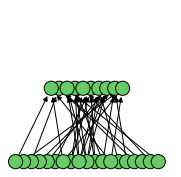

In [128]:
from itertools import product

def resolve_out_to_DAG(out: dict):
    g = nx.DiGraph()

        
    
    for qk, d in out['designs'].items():
        if not len(d['assemblies']):
            print("MISSING ASSEMBLY FOR {}".format(d.keys()))
            continue
        reaction_id = d['assemblies'][0]['final_assembly_reaction'][0]

        assembly_reaction = design_out['reactions'][reaction_id]
        
        in_samples = [out['molecules'][i]['__sample__'] for i in assembly_reaction['inputs']]
        out_samples = [out['molecules'][i]['__sample__'] for i in assembly_reaction['outputs']]
        
        for s1, s2 in product(in_samples, out_samples):
            g.add_edge(s1['name'], s2['name'], reaction_id=reaction_id)
    return g
            
with open('design.out.resolved.json', 'r') as f:
    resolved_out = json.load(f)
    
resolved_graph = resolve_out_to_DAG(resolved_out)
print(nx.info(resolved_graph))
plotter = GraphPlotter(resolved_graph)
plotter.topological_sort()
plotter.draw_graph()
plt.show()

### Convert to Terrarium File

*Note: this 

In [122]:
def init_terrarium_design():
    design_file = {
        'TRAIN': {
            'method': 'last',
            'args': [500],
        },
        'MODEL_PATH': 'terrarium.pkl',
        'GOALS': [],
        "GLOBAL_CONSTRAINTS": {
            "EXCLUDE": [
                {
                    "model_class": "OperationType",
                    "query": [
                        {"category": ["Control Blocks", "Library Cloning"]},
                        {"name": "Yeast Mating"},
                        {"name": "Yeast Auxotrophic Plate Mating"},
                        {'name': 'Order Addgene Plasmid'},
                        {'name': 'Assemble Golden Gate'},
                        {'name': 'Anneal Oligos (Beta)'},
                    ]
                }
            ]
        }
    }
    return design_file

In [127]:
# import terrarium

def iter_leaves(g):
    for n in g.nodes:
        if not list(g.successors(n)):
            yield n
            
def iter_roots(g):
    for n in g.nodes:
        if not list(g.predecessors(n)):
            yield n
        
# nx.draw(resolved_graph)

for n in g.nodes():
    print(n)
# def add_goals(sample_graph, design_file: dict):
#     for leaf in iter_leaves(sample_graph):
#         tree = nx.dfs_tree(sample_graph.reverse(), leaf).reverse()
#         tree = sample_graph.subgraph(list(tree.nodes()))
#         tree_leaves = list(iter_leaves(tree))
#         assert len(tree_leaves) == 1
#         print(leaf)
#     new_goal = {}
#     goal_sample = session.Sample.find_by_name(leaf)
#     new_goal = {
#         'PLAN_ID': "Plant TF",
#         'SAMPLE': {
#             'model_class': 'Sample',
#             'query': {
#                 'name': goal_sample.name
#             }
#         },
#         'OBJECT_TYPE': {
#             'model_class': 'ObjectType',
#             'query': {
#                 'name': 'Plasmid Glycerol Stock'
#             }
#         }
#     }
    
#     new_goal['EDGES'] = []
    
#     for n1, n2 in tree.edges():
#         s1 = session.Sample.find_by_name(n1)
#         s2 = session.Sample.find_by_name(n2)
#         if s1.sample_type.name == 'Fragment':
#             new_goal['EDGES'].append([s1.name, s2.name])
#     new_goal['EDGES'].append(['DH5alpha', goal_sample.name])
            
#     design_file['GOALS'].append(new_goal)
    
# design_file = init_terrarium_design()
# add_goals(resolved_graph, design_file)
    

Primer_PlantTF_2020_Campaign__1984a29f
Fragment_PlantTF_2020_Campaign__cb0e46b1
Primer_PlantTF_2020_Campaign__264b4aeb
pYTK017
Primer_PlantTF_2020_Campaign__c945a6eb
Fragment_PlantTF_2020_Campaign__8a44e29a
j5_0439_(pGpd-TPL100-IAA3-tCyc1)_reverse
pMOD-LTR2-BleoMX-6XZev4-pMinCyc1-ATAF1
Fragment_PlantTF_2020_Campaign__d309e5c0
tp_F(pMOD)
Primer_PlantTF_2020_Campaign__b71f4188
Fragment_PlantTF_2020_Campaign__9030f226
M13-pGREEN_H-r
Fragment_PlantTF_2020_Campaign__eed640c4
290bcaedd06b_fragment_3
Primer_PlantTF_2020_Campaign__d0965b5b
Fragment_PlantTF_2020_Campaign__575353ae
Primer_PlantTF_2020_Campaign__3a3d64ce
pYTK009
Primer_PlantTF_2020_Campaign__e2481e72
Fragment_PlantTF_2020_Campaign__1c96525c
Primer_PlantTF_2020_Campaign__d4837379
pYTK027
Primer_PlantTF_2020_Campaign__7b6baef0
Fragment_PlantTF_2020_Campaign__23d83be1
Primer_PlantTF_2020_Campaign__b62e091d
Fragment_PlantTF_2020_Campaign__7848c9c1
Fragment_PlantTF_2020_Campaign__56bdab7c
Primer_PlantTF_2020_Campaign__29ab61ba


In [113]:
design_file

{'TRAIN': {'method': 'last', 'args': [500]},
 'MODEL_PATH': 'terrarium.pkl',
 'GOALS': [{'PLAN_ID': 'Plant TF',
   'SAMPLE': {'model_class': 'Sample',
    'query': {'name': 'Synthesized_PlantTF_2020_Campaign__3681276b'}},
   'OBJECT_TYPE': {'model_class': 'ObjectType',
    'query': {'name': 'Plasmid Glycerol Stock'}},
   'EDGES': [['DH5alpha', 'Synthesized_PlantTF_2020_Campaign__3681276b']]}],
 'GLOBAL_CONSTRAINTS': {'EXCLUDE': [{'model_class': 'OperationType',
    'query': [{'category': ['Control Blocks', 'Library Cloning']},
     {'name': 'Yeast Mating'},
     {'name': 'Yeast Auxotrophic Plate Mating'},
     {'name': 'Order Addgene Plasmid'},
     {'name': 'Assemble Golden Gate'},
     {'name': 'Anneal Oligos (Beta)'}]}]}}

In [ ]:
import terrarium
import json

rev_sample_graph = sample_graph.reverse()

for leaf in iter_leaves(sample_graph):
    tree = nx.dfs_tree(rev_sample_graph, leaf).reverse()
    tree = sample_graph.subgraph(list(tree.nodes()))
    tree_leaves = list(iter_leaves(tree))
    assert len(tree_leaves) == 1
    
    
    new_goal = {}
    goal_sample = session.Sample.find(leaf)
    new_goal = {
        'PLAN_ID': "Plant TF (Terrarium {})".format(terrarium.__version__),
        'SAMPLE': {
            'model_class': 'Sample',
            'query': {
                'name': goal_sample.name
            }
        },
        'OBJECT_TYPE': {
            'model_class': 'ObjectType',
            'query': {
                'name': 'Plasmid Glycerol Stock'
            }
        }
    }
    
    new_goal['EDGES'] = []
    
    for n1, n2 in tree.edges():
        s1 = session.Sample.find(n1)
        s2 = session.Sample.find(n2)
        if s1.sample_type.name == 'Fragment':
            new_goal['EDGES'].append([s1.name, s2.name])
    new_goal['EDGES'].append(['DH5alpha', goal_sample.name])
            
    design_file['GOALS'].append(new_goal)

visited = []
GOALS = []
for g in design_file['GOALS']:
    name = g['SAMPLE']['query']['name']
    if '__single_bs' in name and name not in visited:
        GOALS.append(g)
        visited.append(name)
        
design_file['GOALS'] = GOALS
with open(TERRARIUM_IN, 'w') as f:
    json.dump(design_file, f, indent=2)